In [1]:
from salishsea_tools import grid_tools, nc_tools, timeseries_tools, viz_tools
import visualisations
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import netCDF4 as nc
import xarray as xr
import datetime
from scipy import signal
import cmocean
import statsmodels.api as sm
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
from matplotlib import animation, rc
rc('animation', html='html5')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [4]:
mesh = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')

In [6]:
bathy = nc.Dataset('/data/vdo/MEOPAR/grid/bathymetry_201702.nc')

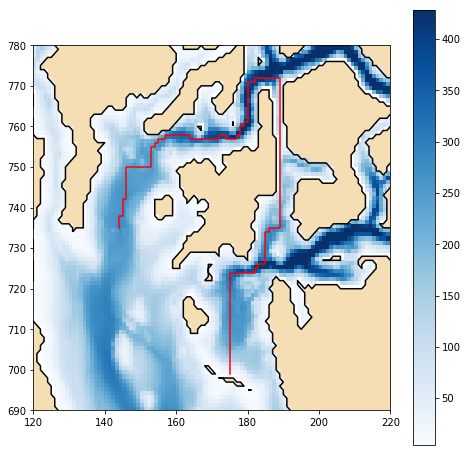

In [26]:
bs_thalweg0 = np.loadtxt('ds_thalweg.txt')
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
ax.set_xlim(120, 220)
ax.set_ylim(690,780)
viz_tools.set_aspect(ax)
viz_tools.plot_coastline(ax, bathy)
viz_tools.plot_land_mask(ax, bathy, color = 'wheat')
b = ax.pcolormesh(bathy.variables['Bathymetry'][:], cmap = 'Blues')
fig.colorbar(b, ax=ax);
#ax.grid('on');

In [10]:
from salishsea_tools import visualisations as vis2

In [11]:
import visualisations

In [12]:
import matplotlib.gridspec as gridspec

In [13]:
grid = xr.open_dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
mesh_mask = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc')
winds_data = xr.open_dataset(
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
N = 1
Wn = 1/24
B, A = signal.butter(N,Wn)

# Quadra full

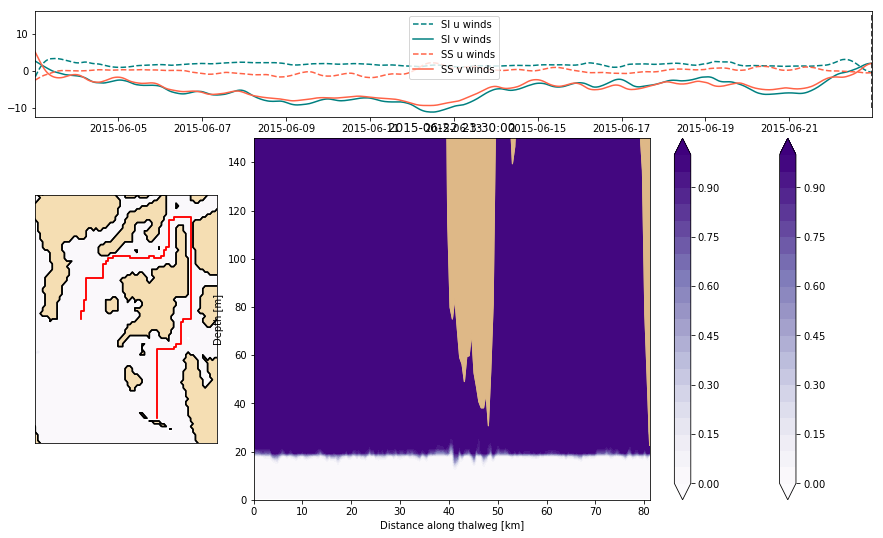

In [14]:
trc_full = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs2/03jun15/SalishSea_1h_20150603_20150622_ptrc_T.nc')
fig, ax = plt.subplots(figsize = (15,9))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1:, 0])
ax3 = plt.subplot(gs[1:, 1:])
first = nc.num2date(trc_full.variables['time_counter'][0], 
                        trc_full.variables['time_counter'].units)
dates = nc.num2date(trc_full.variables['time_counter'][:], trc_full.variables['time_counter'].units)
end_index = trc_full.variables['time_counter'][:].shape[0]
times = np.array([first + datetime.timedelta(hours = i) for i in range(end_index)])
averaged_SI_u_winds = np.array([])
averaged_SI_v_winds = np.array([])
averaged_SS_u_winds = np.array([])
averaged_SS_v_winds = np.array([])
for n in range(end_index):
    SI_u_winds = winds_data.u_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_u_winds = np.append(averaged_SI_u_winds, np.mean(SI_u_winds))
    SI_v_winds = winds_data.v_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_v_winds = np.append(averaged_SI_v_winds, np.mean(SI_v_winds))
    SS_u_winds = winds_data.u_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_u_winds = np.append(averaged_SS_u_winds, np.mean(SS_u_winds))
    SS_v_winds = winds_data.v_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_v_winds = np.append(averaged_SS_v_winds, np.mean(SS_v_winds))
rotated_SI_u_winds, rotated_SI_v_winds = viz_tools.rotate_vel(averaged_SI_u_winds, 
                                                              averaged_SI_v_winds, 
                                                              origin = 'map' )
rotated_SS_u_winds, rotated_SS_v_winds = viz_tools.rotate_vel(averaged_SS_u_winds, 
                                                              averaged_SS_v_winds, 
                                                              origin = 'map' )
SIwindfu = signal.filtfilt(B,A, rotated_SI_u_winds)
SIwindfv = signal.filtfilt(B,A, rotated_SI_v_winds)
SSwindfu = signal.filtfilt(B,A, rotated_SS_u_winds)
SSwindfv = signal.filtfilt(B,A, rotated_SS_v_winds)
def init():
    vis2.contour_thalweg(ax3, trc_full.variables['mytracer3'][0,...], 
                         bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][0,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    viz_tools.set_aspect(ax2)
def animate30(i):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax1.plot(times, SIwindfu, '--', color = 'teal', label = 'SI u winds')
    ax1.plot(times, SIwindfv, '-', color = 'teal', label = 'SI v winds')
    ax1.plot(times, SSwindfu, '--', color = 'tomato', label = 'SS u winds')
    ax1.plot(times, SSwindfv, '-', color = 'tomato', label = 'SS v winds')
    ax1.plot((dates[i], dates[i]), (-10,15), 'b--', color = 'black')
    ax1.legend()
    ax1.set_xlim(dates[0], dates[-1])
    visualisations.contour_thalweg(ax3, trc_full.variables['mytracer3'][i,...], 
                                   bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax3.set_ylim(150, 0)
    ax3.set_title(dates[i])
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][i,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return ax
interval = 0.2#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=end_index,init_func = init, 
                                interval=interval*1e+3, repeat=False)
ani40

# Quadra Lake

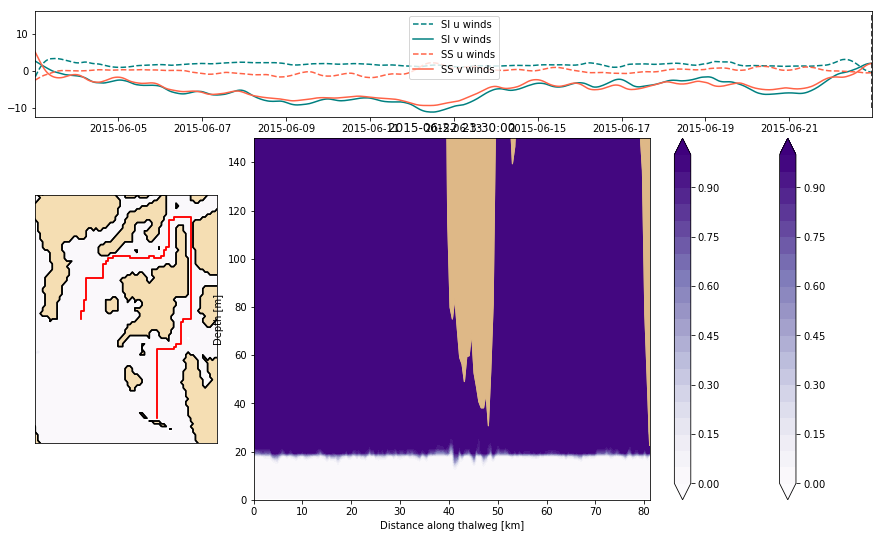

In [17]:
trc_full = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs2/03jun15lake/SalishSea_1h_20150603_20150622_ptrc_T.nc')
fig, ax = plt.subplots(figsize = (15,9))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1:, 0])
ax3 = plt.subplot(gs[1:, 1:])
first = nc.num2date(trc_full.variables['time_counter'][0], 
                        trc_full.variables['time_counter'].units)
dates = nc.num2date(trc_full.variables['time_counter'][:], trc_full.variables['time_counter'].units)
end_index = trc_full.variables['time_counter'][:].shape[0]
times = np.array([first + datetime.timedelta(hours = i) for i in range(end_index)])
averaged_SI_u_winds = np.array([])
averaged_SI_v_winds = np.array([])
averaged_SS_u_winds = np.array([])
averaged_SS_v_winds = np.array([])
for n in range(end_index):
    SI_u_winds = winds_data.u_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_u_winds = np.append(averaged_SI_u_winds, np.mean(SI_u_winds))
    SI_v_winds = winds_data.v_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_v_winds = np.append(averaged_SI_v_winds, np.mean(SI_v_winds))
    SS_u_winds = winds_data.u_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_u_winds = np.append(averaged_SS_u_winds, np.mean(SS_u_winds))
    SS_v_winds = winds_data.v_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_v_winds = np.append(averaged_SS_v_winds, np.mean(SS_v_winds))
rotated_SI_u_winds, rotated_SI_v_winds = viz_tools.rotate_vel(averaged_SI_u_winds, 
                                                              averaged_SI_v_winds, 
                                                              origin = 'map' )
rotated_SS_u_winds, rotated_SS_v_winds = viz_tools.rotate_vel(averaged_SS_u_winds, 
                                                              averaged_SS_v_winds, 
                                                              origin = 'map' )
SIwindfu = signal.filtfilt(B,A, rotated_SI_u_winds)
SIwindfv = signal.filtfilt(B,A, rotated_SI_v_winds)
SSwindfu = signal.filtfilt(B,A, rotated_SS_u_winds)
SSwindfv = signal.filtfilt(B,A, rotated_SS_v_winds)
def init():
    vis2.contour_thalweg(ax3, trc_full.variables['mytracer3'][0,...], 
                         bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][0,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    viz_tools.set_aspect(ax2)
def animate30(i):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax1.plot(times, SIwindfu, '--', color = 'teal', label = 'SI u winds')
    ax1.plot(times, SIwindfv, '-', color = 'teal', label = 'SI v winds')
    ax1.plot(times, SSwindfu, '--', color = 'tomato', label = 'SS u winds')
    ax1.plot(times, SSwindfv, '-', color = 'tomato', label = 'SS v winds')
    ax1.plot((dates[i], dates[i]), (-10,15), 'b--', color = 'black')
    ax1.legend()
    ax1.set_xlim(dates[0], dates[-1])
    visualisations.contour_thalweg(ax3, trc_full.variables['mytracer3'][i,...], 
                                   bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax3.set_ylim(150, 0)
    ax3.set_title(dates[i])
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][i,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return ax
interval = 0.2#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=end_index,init_func = init, 
                                interval=interval*1e+3, repeat=False)
ani40

# Desolation Sound full

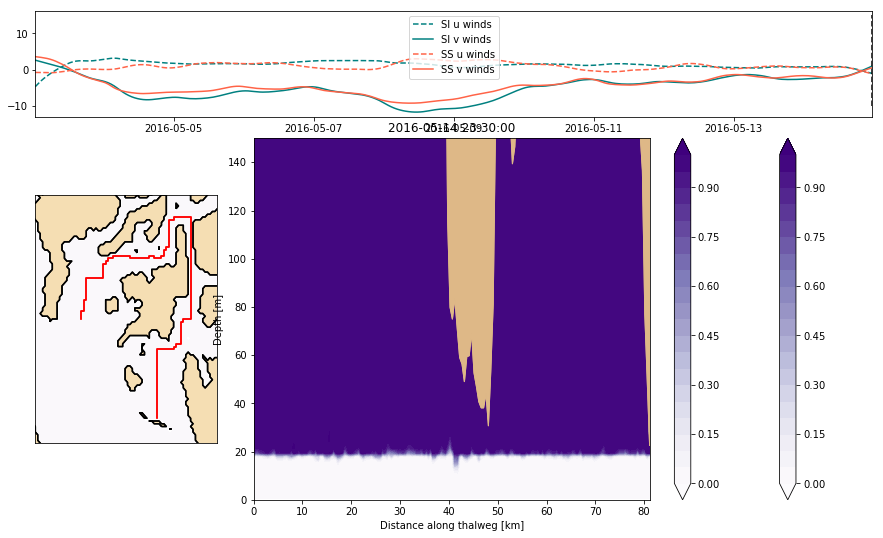

In [18]:
trc_full = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs2/03may16/SalishSea_1h_20160503_20160514_ptrc_T.nc')
fig, ax = plt.subplots(figsize = (15,9))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1:, 0])
ax3 = plt.subplot(gs[1:, 1:])
first = nc.num2date(trc_full.variables['time_counter'][0], 
                        trc_full.variables['time_counter'].units)
dates = nc.num2date(trc_full.variables['time_counter'][:], trc_full.variables['time_counter'].units)
end_index = trc_full.variables['time_counter'][:].shape[0]
times = np.array([first + datetime.timedelta(hours = i) for i in range(end_index)])
averaged_SI_u_winds = np.array([])
averaged_SI_v_winds = np.array([])
averaged_SS_u_winds = np.array([])
averaged_SS_v_winds = np.array([])
for n in range(end_index):
    SI_u_winds = winds_data.u_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_u_winds = np.append(averaged_SI_u_winds, np.mean(SI_u_winds))
    SI_v_winds = winds_data.v_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_v_winds = np.append(averaged_SI_v_winds, np.mean(SI_v_winds))
    SS_u_winds = winds_data.u_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_u_winds = np.append(averaged_SS_u_winds, np.mean(SS_u_winds))
    SS_v_winds = winds_data.v_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_v_winds = np.append(averaged_SS_v_winds, np.mean(SS_v_winds))
rotated_SI_u_winds, rotated_SI_v_winds = viz_tools.rotate_vel(averaged_SI_u_winds, 
                                                              averaged_SI_v_winds, 
                                                              origin = 'map' )
rotated_SS_u_winds, rotated_SS_v_winds = viz_tools.rotate_vel(averaged_SS_u_winds, 
                                                              averaged_SS_v_winds, 
                                                              origin = 'map' )
SIwindfu = signal.filtfilt(B,A, rotated_SI_u_winds)
SIwindfv = signal.filtfilt(B,A, rotated_SI_v_winds)
SSwindfu = signal.filtfilt(B,A, rotated_SS_u_winds)
SSwindfv = signal.filtfilt(B,A, rotated_SS_v_winds)
def init():
    vis2.contour_thalweg(ax3, trc_full.variables['mytracer3'][0,...], 
                         bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][0,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    viz_tools.set_aspect(ax2)
def animate30(i):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax1.plot(times, SIwindfu, '--', color = 'teal', label = 'SI u winds')
    ax1.plot(times, SIwindfv, '-', color = 'teal', label = 'SI v winds')
    ax1.plot(times, SSwindfu, '--', color = 'tomato', label = 'SS u winds')
    ax1.plot(times, SSwindfv, '-', color = 'tomato', label = 'SS v winds')
    ax1.plot((dates[i], dates[i]), (-10,15), 'b--', color = 'black')
    ax1.legend()
    ax1.set_xlim(dates[0], dates[-1])
    visualisations.contour_thalweg(ax3, trc_full.variables['mytracer3'][i,...], 
                                   bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax3.set_ylim(150, 0)
    ax3.set_title(dates[i])
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][i,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return ax
interval = 0.2#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=end_index,init_func = init, 
                                interval=interval*1e+3, repeat=False)
ani40

# Desolation Sound Lake

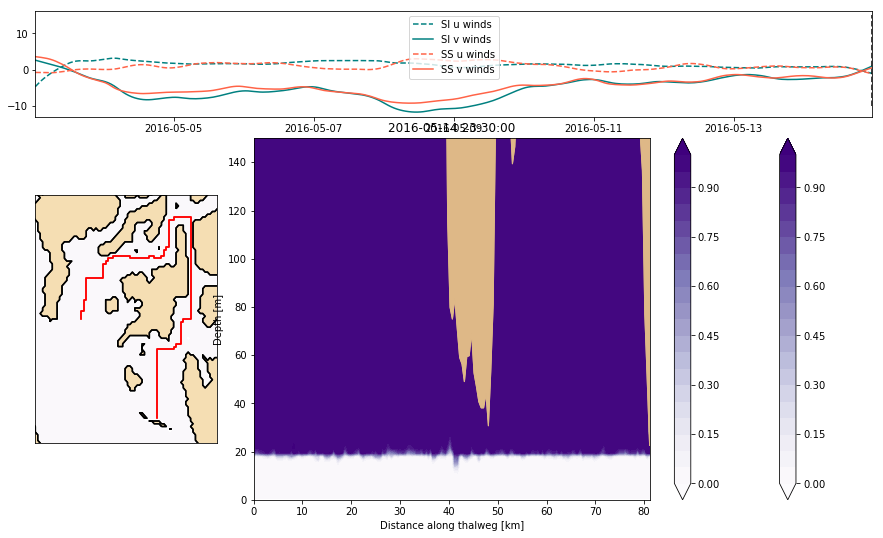

In [19]:
trc_full = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs2/03may16lake/SalishSea_1h_20160503_20160514_ptrc_T.nc')
fig, ax = plt.subplots(figsize = (15,9))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1:, 0])
ax3 = plt.subplot(gs[1:, 1:])
first = nc.num2date(trc_full.variables['time_counter'][0], 
                        trc_full.variables['time_counter'].units)
dates = nc.num2date(trc_full.variables['time_counter'][:], trc_full.variables['time_counter'].units)
end_index = trc_full.variables['time_counter'][:].shape[0]
times = np.array([first + datetime.timedelta(hours = i) for i in range(end_index)])
averaged_SI_u_winds = np.array([])
averaged_SI_v_winds = np.array([])
averaged_SS_u_winds = np.array([])
averaged_SS_v_winds = np.array([])
for n in range(end_index):
    SI_u_winds = winds_data.u_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_u_winds = np.append(averaged_SI_u_winds, np.mean(SI_u_winds))
    SI_v_winds = winds_data.v_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_v_winds = np.append(averaged_SI_v_winds, np.mean(SI_v_winds))
    SS_u_winds = winds_data.u_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_u_winds = np.append(averaged_SS_u_winds, np.mean(SS_u_winds))
    SS_v_winds = winds_data.v_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_v_winds = np.append(averaged_SS_v_winds, np.mean(SS_v_winds))
rotated_SI_u_winds, rotated_SI_v_winds = viz_tools.rotate_vel(averaged_SI_u_winds, 
                                                              averaged_SI_v_winds, 
                                                              origin = 'map' )
rotated_SS_u_winds, rotated_SS_v_winds = viz_tools.rotate_vel(averaged_SS_u_winds, 
                                                              averaged_SS_v_winds, 
                                                              origin = 'map' )
SIwindfu = signal.filtfilt(B,A, rotated_SI_u_winds)
SIwindfv = signal.filtfilt(B,A, rotated_SI_v_winds)
SSwindfu = signal.filtfilt(B,A, rotated_SS_u_winds)
SSwindfv = signal.filtfilt(B,A, rotated_SS_v_winds)
def init():
    vis2.contour_thalweg(ax3, trc_full.variables['mytracer3'][0,...], 
                         bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][0,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    viz_tools.set_aspect(ax2)
def animate30(i):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax1.plot(times, SIwindfu, '--', color = 'teal', label = 'SI u winds')
    ax1.plot(times, SIwindfv, '-', color = 'teal', label = 'SI v winds')
    ax1.plot(times, SSwindfu, '--', color = 'tomato', label = 'SS u winds')
    ax1.plot(times, SSwindfv, '-', color = 'tomato', label = 'SS v winds')
    ax1.plot((dates[i], dates[i]), (-10,15), 'b--', color = 'black')
    ax1.legend()
    ax1.set_xlim(dates[0], dates[-1])
    visualisations.contour_thalweg(ax3, trc_full.variables['mytracer3'][i,...], 
                                   bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'ds_thalweg.txt')
    ax3.set_ylim(150, 0)
    ax3.set_title(dates[i])
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][i,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(125, 200)
    ax2.set_ylim(690,780)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return ax
interval = 0.2#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=end_index,init_func = init, 
                                interval=interval*1e+3, repeat=False)
ani40

# Baynes Sound full

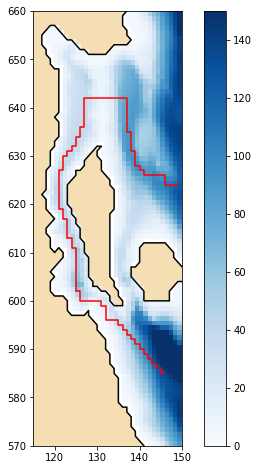

In [27]:
bs_thalweg0 = np.loadtxt('bs_thalweg.txt')
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
ax.set_xlim(115, 150)
ax.set_ylim(570,660)
viz_tools.set_aspect(ax)
viz_tools.plot_coastline(ax, bathy)
viz_tools.plot_land_mask(ax, bathy, color = 'wheat')
b = ax.pcolormesh(bathy.variables['Bathymetry'][:], cmap = 'Blues', vmin = 0, vmax = 150)
fig.colorbar(b, ax=ax);
#ax.grid('on');

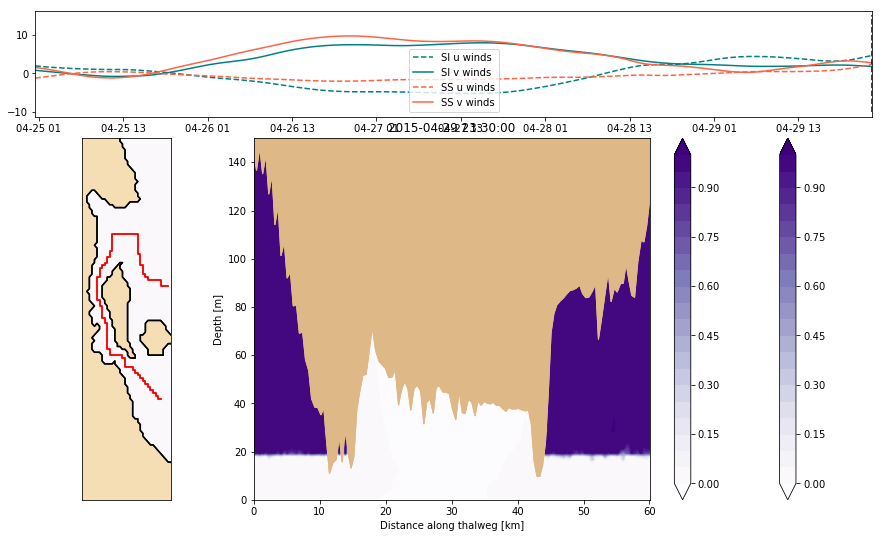

In [28]:
trc_full = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs2/25apr15/SalishSea_1h_20150425_20150429_ptrc_T.nc')
fig, ax = plt.subplots(figsize = (15,9))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1:, 0])
ax3 = plt.subplot(gs[1:, 1:])
first = nc.num2date(trc_full.variables['time_counter'][0], 
                        trc_full.variables['time_counter'].units)
dates = nc.num2date(trc_full.variables['time_counter'][:], trc_full.variables['time_counter'].units)
end_index = trc_full.variables['time_counter'][:].shape[0]
times = np.array([first + datetime.timedelta(hours = i) for i in range(end_index)])
averaged_SI_u_winds = np.array([])
averaged_SI_v_winds = np.array([])
averaged_SS_u_winds = np.array([])
averaged_SS_v_winds = np.array([])
for n in range(end_index):
    SI_u_winds = winds_data.u_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_u_winds = np.append(averaged_SI_u_winds, np.mean(SI_u_winds))
    SI_v_winds = winds_data.v_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_v_winds = np.append(averaged_SI_v_winds, np.mean(SI_v_winds))
    SS_u_winds = winds_data.u_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_u_winds = np.append(averaged_SS_u_winds, np.mean(SS_u_winds))
    SS_v_winds = winds_data.v_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_v_winds = np.append(averaged_SS_v_winds, np.mean(SS_v_winds))
rotated_SI_u_winds, rotated_SI_v_winds = viz_tools.rotate_vel(averaged_SI_u_winds, 
                                                              averaged_SI_v_winds, 
                                                              origin = 'map' )
rotated_SS_u_winds, rotated_SS_v_winds = viz_tools.rotate_vel(averaged_SS_u_winds, 
                                                              averaged_SS_v_winds, 
                                                              origin = 'map' )
SIwindfu = signal.filtfilt(B,A, rotated_SI_u_winds)
SIwindfv = signal.filtfilt(B,A, rotated_SI_v_winds)
SSwindfu = signal.filtfilt(B,A, rotated_SS_u_winds)
SSwindfv = signal.filtfilt(B,A, rotated_SS_v_winds)
def init():
    vis2.contour_thalweg(ax3, trc_full.variables['mytracer3'][0,...], 
                         bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'bs_thalweg.txt')
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][0,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(115, 150)
    ax2.set_ylim(550,675)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    viz_tools.set_aspect(ax2)
def animate30(i):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax1.plot(times, SIwindfu, '--', color = 'teal', label = 'SI u winds')
    ax1.plot(times, SIwindfv, '-', color = 'teal', label = 'SI v winds')
    ax1.plot(times, SSwindfu, '--', color = 'tomato', label = 'SS u winds')
    ax1.plot(times, SSwindfv, '-', color = 'tomato', label = 'SS v winds')
    ax1.plot((dates[i], dates[i]), (-10,15), 'b--', color = 'black')
    ax1.legend()
    ax1.set_xlim(dates[0], dates[-1])
    visualisations.contour_thalweg(ax3, trc_full.variables['mytracer3'][i,...], 
                                   bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'bs_thalweg.txt')
    ax3.set_ylim(150, 0)
    ax3.set_title(dates[i])
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][i,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(115, 150)
    ax2.set_ylim(550,675)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return ax
interval = 0.2#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=end_index,init_func = init, 
                                interval=interval*1e+3, repeat=False)
ani40

# Baynes Sound Lake

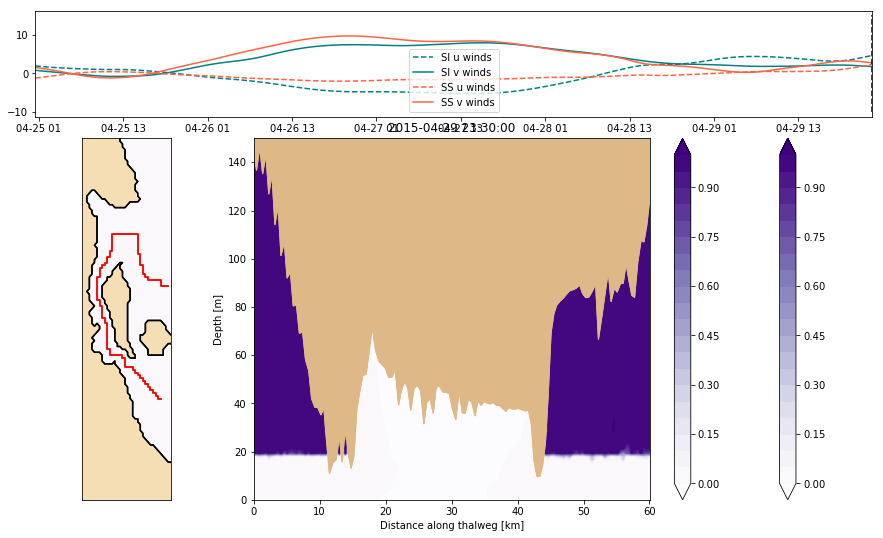

In [29]:
trc_full = nc.Dataset('/data/vdo/MEOPAR/completed-runs/stats-runs2/25apr15lake/SalishSea_1h_20150425_20150429_ptrc_T.nc')
fig, ax = plt.subplots(figsize = (15,9))
gs = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1:, 0])
ax3 = plt.subplot(gs[1:, 1:])
first = nc.num2date(trc_full.variables['time_counter'][0], 
                        trc_full.variables['time_counter'].units)
dates = nc.num2date(trc_full.variables['time_counter'][:], trc_full.variables['time_counter'].units)
end_index = trc_full.variables['time_counter'][:].shape[0]
times = np.array([first + datetime.timedelta(hours = i) for i in range(end_index)])
averaged_SI_u_winds = np.array([])
averaged_SI_v_winds = np.array([])
averaged_SS_u_winds = np.array([])
averaged_SS_v_winds = np.array([])
for n in range(end_index):
    SI_u_winds = winds_data.u_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_u_winds = np.append(averaged_SI_u_winds, np.mean(SI_u_winds))
    SI_v_winds = winds_data.v_wind.isel(gridY=slice(159,162), 
                                        gridX=slice(119,122)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SI_v_winds = np.append(averaged_SI_v_winds, np.mean(SI_v_winds))
    SS_u_winds = winds_data.u_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_u_winds = np.append(averaged_SS_u_winds, np.mean(SS_u_winds))
    SS_v_winds = winds_data.v_wind.isel(gridY=slice(182,185), 
                                        gridX=slice(106,109)).sel(time=times[n], 
                                                                  method = 'nearest').values
    averaged_SS_v_winds = np.append(averaged_SS_v_winds, np.mean(SS_v_winds))
rotated_SI_u_winds, rotated_SI_v_winds = viz_tools.rotate_vel(averaged_SI_u_winds, 
                                                              averaged_SI_v_winds, 
                                                              origin = 'map' )
rotated_SS_u_winds, rotated_SS_v_winds = viz_tools.rotate_vel(averaged_SS_u_winds, 
                                                              averaged_SS_v_winds, 
                                                              origin = 'map' )
SIwindfu = signal.filtfilt(B,A, rotated_SI_u_winds)
SIwindfv = signal.filtfilt(B,A, rotated_SI_v_winds)
SSwindfu = signal.filtfilt(B,A, rotated_SS_u_winds)
SSwindfv = signal.filtfilt(B,A, rotated_SS_v_winds)
def init():
    vis2.contour_thalweg(ax3, trc_full.variables['mytracer3'][0,...], 
                         bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'bs_thalweg.txt')
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][0,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(115, 150)
    ax2.set_ylim(550,675)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    viz_tools.set_aspect(ax2)
def animate30(i):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax1.plot(times, SIwindfu, '--', color = 'teal', label = 'SI u winds')
    ax1.plot(times, SIwindfv, '-', color = 'teal', label = 'SI v winds')
    ax1.plot(times, SSwindfu, '--', color = 'tomato', label = 'SS u winds')
    ax1.plot(times, SSwindfv, '-', color = 'tomato', label = 'SS v winds')
    ax1.plot((dates[i], dates[i]), (-10,15), 'b--', color = 'black')
    ax1.legend()
    ax1.set_xlim(dates[0], dates[-1])
    visualisations.contour_thalweg(ax3, trc_full.variables['mytracer3'][i,...], 
                                   bathy, mesh_mask, np.arange(0,1.05,0.05), cmap = 'Purples',
                              thalweg_file = 'bs_thalweg.txt')
    ax3.set_ylim(150, 0)
    ax3.set_title(dates[i])
    ax2.contourf(np.ma.masked_array(trc_full.variables['mytracer3'][i,0,...], 
                                    mask= 1 - mesh.variables['tmask'][0,0,...]),
                    cmap = 'Purples', levels = np.arange(0,1.05, 0.05))
    ax2.plot(bs_thalweg0[:,1], bs_thalweg0[:,0], 'r')
    ax2.set_xlim(115, 150)
    ax2.set_ylim(550,675)
    viz_tools.set_aspect(ax2)
    viz_tools.plot_coastline(ax2, bathy)
    viz_tools.plot_land_mask(ax2, bathy, color = 'wheat')
    ax2.set_yticks([])
    ax2.set_xticks([])
    return ax
interval = 0.2#in seconds
ani40 = animation.FuncAnimation(fig,animate30,frames=end_index,init_func = init, 
                                interval=interval*1e+3, repeat=False)
ani40

In [30]:
2160*16

34560